# Estatísticas dos parâmetros de um modelo

1. Faça uma função que receba como entrada uma rede neural e retorne um dicionário no qual cada chave é o nome de um tensor de parâmetros do modelo e os respectivos valores são:
    * O maior e menor valor do tensor;
    * O maior e menor valor do gradiente do tensor;
2. Faça uma função que receba o dicionário de 1 e retorne o menor e maior valor dentre todos os parâmetros e todos os gradientes (4 valores no total);
3. Modifique o script de treinamento visto nas aulas para plotar além da loss e da acurácia, os menores e maiores valores retornados em 2. Crie um terceiro gráfico (além do gráfico da loss e acurácia), para mostrar os valores. Os valores devem ser plotados **durante o treinamento da rede**

In [1]:
import torch
from torch import nn
from torchvision import models
import torch.optim as optim
import math

# Carregar o modelo com pesos pré-treinados
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model.eval()

# Criar dados de entrada fictícios
dummy_input = torch.rand(1, 3, 224, 224)

# Realizar um pass forward
outputs = model(dummy_input)

# Calcular uma perda fictícia
criterion = nn.CrossEntropyLoss()
dummy_labels = torch.randint(0, 1000, (dummy_input.size(0),))
loss = criterion(outputs, dummy_labels)

# Chamar loss.backward() para calcular os gradientes
for param in model.parameters():
    if param.grad is not None:
        param.grad.zero_()

loss.backward()

print("Modelo pré-treinado carregado e gradientes calculados após uma passagem backward.")

Modelo pré-treinado carregado e gradientes calculados após uma passagem backward.


In [2]:
import torch
from torchvision import models
import math

def get_param_stats(model):
    """
    Calcula estatísticas (min/max de parâmetros e gradientes) para cada tensor de parâmetros do modelo.
    """
    stats = {}
    for name, param in model.named_parameters():
        current_stats = {}
        if param.data is not None:
            current_stats['param_max'] = param.data.max().item()
            current_stats['param_min'] = param.data.min().item()
        else:
            current_stats['param_max'] = float('nan')
            current_stats['param_min'] = float('nan')

        if param.requires_grad:
            if param.grad is not None:
                current_stats['grad_max'] = param.grad.data.max().item()
                current_stats['grad_min'] = param.grad.data.min().item()
            else:
                # Gradientes podem ser None antes do primeiro backward() ou se não foram acumulados
                current_stats['grad_max'] = float('nan')
                current_stats['grad_min'] = float('nan')
        else:
            # Parâmetros que não precisam de gradientes
            current_stats['grad_max'] = float('nan')
            current_stats['grad_min'] = float('nan')
        stats[name] = current_stats
    return stats

def get_global_stats(param_stats_dict):
    """
    Calcula estatísticas globais (min/max de todos os parâmetros e todos os gradientes)
    a partir do dicionário gerado por get_param_stats.
    """
    all_param_mins = []
    all_param_maxs = []
    all_grad_mins = []
    all_grad_maxs = []

    for name, data in param_stats_dict.items():
        if 'param_min' in data and not (isinstance(data['param_min'], float) and math.isnan(data['param_min'])):
            all_param_mins.append(data['param_min'])
        if 'param_max' in data and not (isinstance(data['param_max'], float) and math.isnan(data['param_max'])):
            all_param_maxs.append(data['param_max'])
        
        if 'grad_min' in data and not (isinstance(data['grad_min'], float) and math.isnan(data['grad_min'])):
            all_grad_mins.append(data['grad_min'])
        if 'grad_max' in data and not (isinstance(data['grad_max'], float) and math.isnan(data['grad_max'])):
            all_grad_maxs.append(data['grad_max'])

    overall_param_min = min(all_param_mins) if all_param_mins else float('nan')
    overall_param_max = max(all_param_maxs) if all_param_maxs else float('nan')
    overall_grad_min = min(all_grad_mins) if all_grad_mins else float('nan')
    overall_grad_max = max(all_grad_maxs) if all_grad_maxs else float('nan')
            
    return overall_param_min, overall_param_max, overall_grad_min, overall_grad_max


# Aplicando ao modelo da célula anterior que já teve o backward feito
if 'model' in globals() and any(p.grad is not None for p in model.parameters() if p.requires_grad):
    param_stats = get_param_stats(model)
    
    overall_param_min, overall_param_max, overall_grad_min, overall_grad_max = get_global_stats(param_stats)

    print(f"Menor valor global de parâmetro: {overall_param_min}")
    print(f"Maior valor global de parâmetro: {overall_param_max}")
    print(f"Menor valor global de gradiente: {overall_grad_min}")
    print(f"Maior valor global de gradiente: {overall_grad_max}")
else:
    print("Execute a célula anterior para inicializar o modelo e calcular os gradientes antes de rodar este exemplo.")


Menor valor global de parâmetro: -0.8433799147605896
Maior valor global de parâmetro: 2.407539129257202
Menor valor global de gradiente: -9.594504356384277
Maior valor global de gradiente: 12.479618072509766


Agora, vamos modificar um script de treinamento para incluir a plotagem das estatísticas dos parâmetros e gradientes, além da loss e acurácia, durante o treinamento.

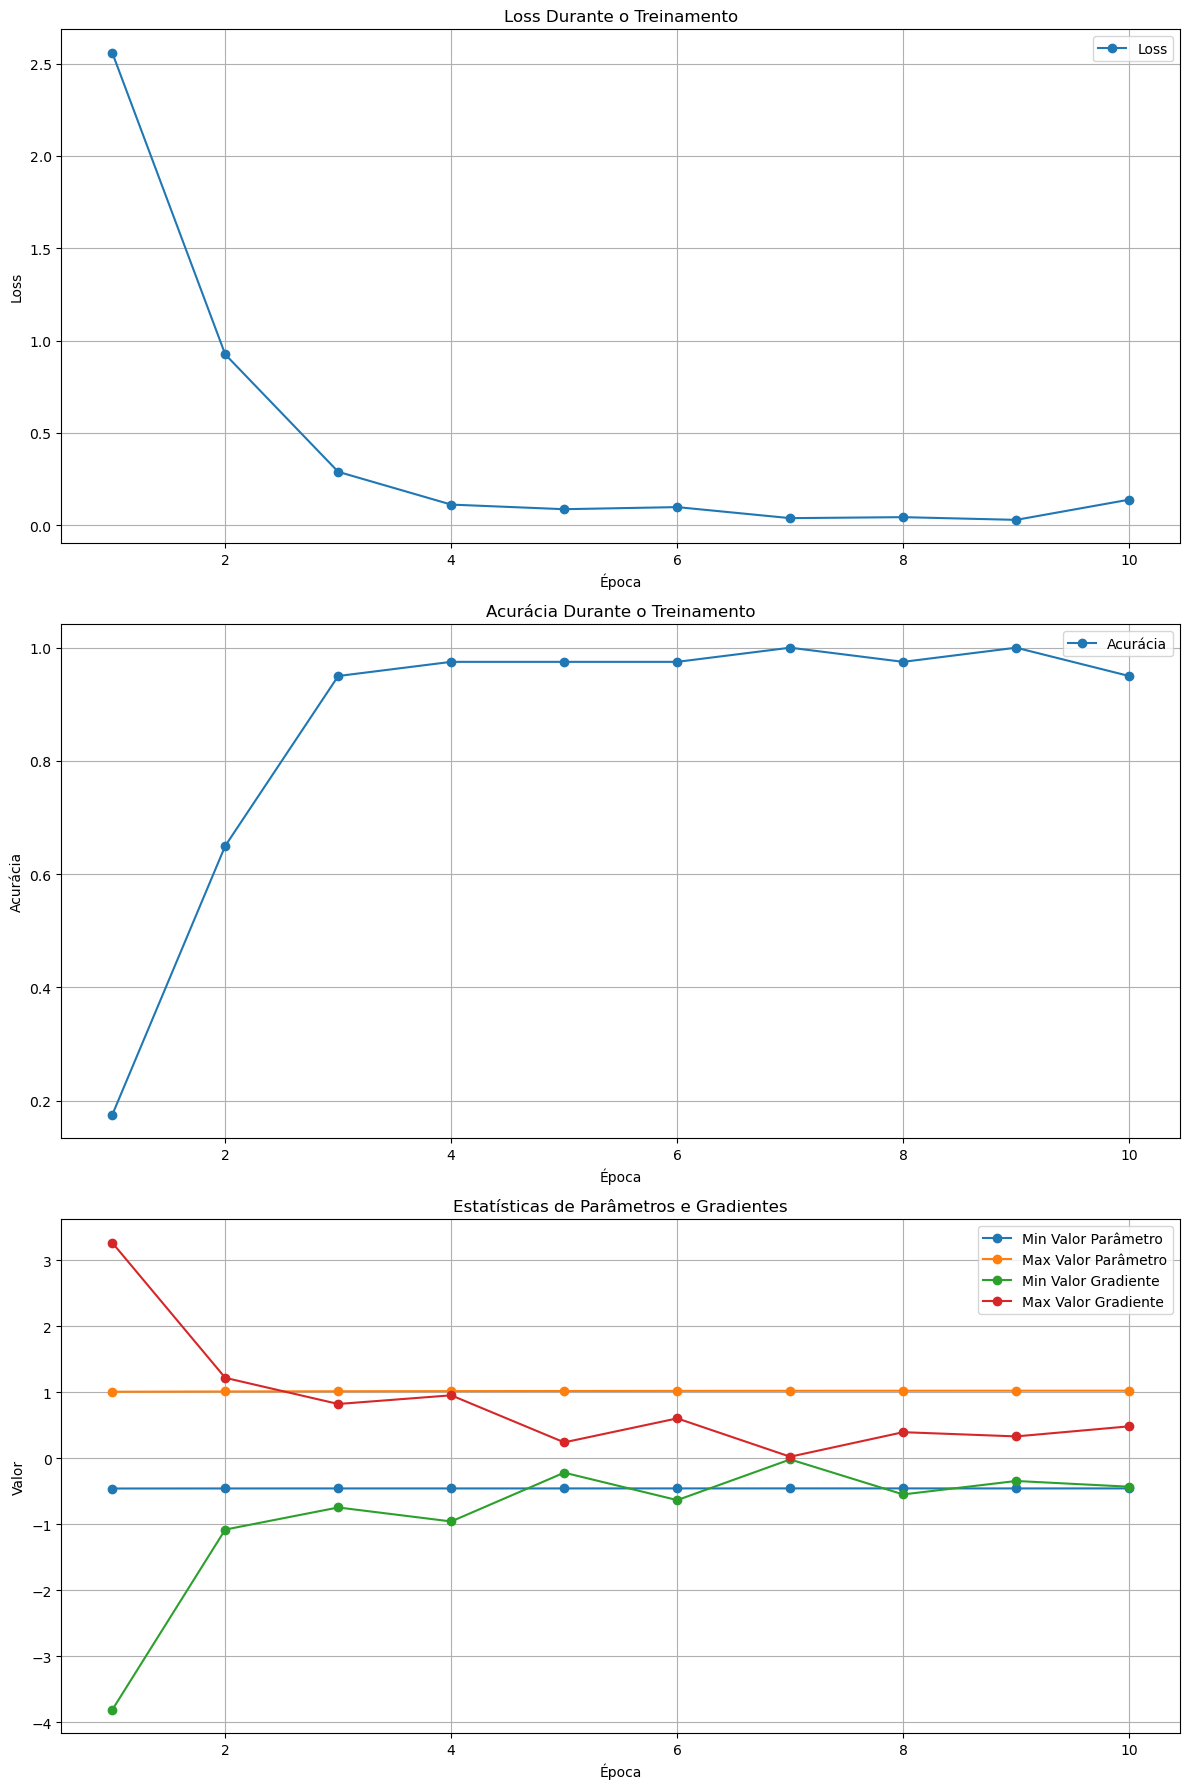

Época 10/10 - Loss: 0.1390 - Acurácia: 0.9500
Stats - Param (Min: -4.60e-01, Max: 1.02e+00), Grad (Min: -4.34e-01, Max: 4.80e-01)
Treinamento concluído!


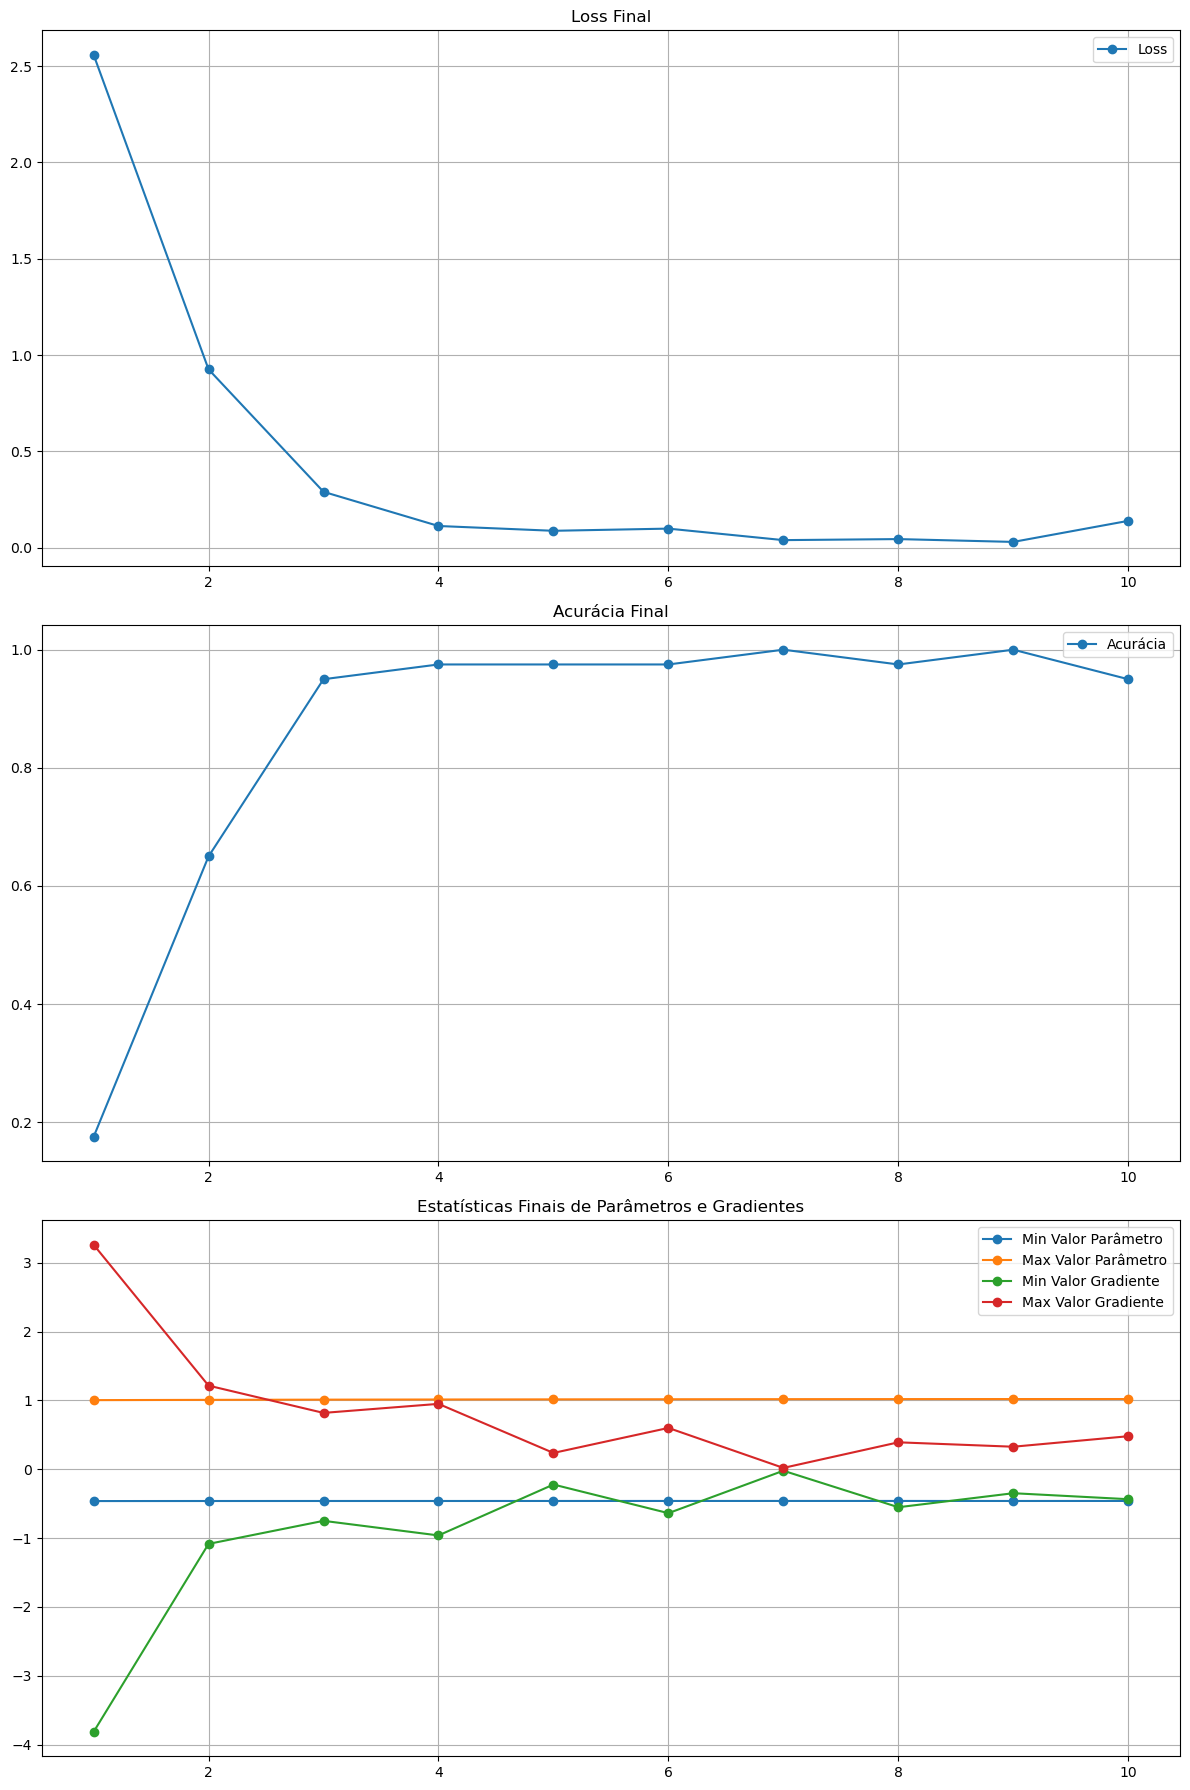

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
import math

# Configurações do Treinamento
NUM_EPOCHS = 10
BATCH_SIZE = 8 # Reduzido para rodar mais rápido no exemplo
NUM_CLASSES = 10
LEARNING_RATE = 0.001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Modelo (usaremos ResNet18 sem pesos pré-treinados para este exemplo)
train_model = models.resnet18(weights=None, num_classes=NUM_CLASSES).to(DEVICE)

# Dados fictícios (dummy data)
# Para ResNet18, a entrada é normalmente (N, 3, H, W)
dummy_images = torch.randn(BATCH_SIZE * 5, 3, 32, 32).to(DEVICE) # 5 batches de dados
dummy_labels = torch.randint(0, NUM_CLASSES, (BATCH_SIZE * 5,)).to(DEVICE)
dummy_dataset = TensorDataset(dummy_images, dummy_labels)
dummy_loader = DataLoader(dummy_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Loss e Otimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(train_model.parameters(), lr=LEARNING_RATE)

# Listas para armazenar o histórico
history = {
    'loss': [], 'accuracy': [],
    'param_min': [], 'param_max': [],
    'grad_min': [], 'grad_max': []
}

print(f"Iniciando treinamento em {DEVICE} por {NUM_EPOCHS} épocas...")

for epoch in range(NUM_EPOCHS):
    train_model.train()
    epoch_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for inputs, labels in dummy_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = train_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    # Calcular estatísticas dos parâmetros e gradientes
    param_stats_epoch = get_param_stats(train_model)
    p_min, p_max, g_min, g_max = get_global_stats(param_stats_epoch)

    # Salvar métricas
    avg_epoch_loss = epoch_loss / total_samples
    epoch_accuracy = correct_predictions / total_samples
    
    history['loss'].append(avg_epoch_loss)
    history['accuracy'].append(epoch_accuracy)
    history['param_min'].append(p_min)
    history['param_max'].append(p_max)
    history['grad_min'].append(g_min)
    history['grad_max'].append(g_max)

    # Plotar
    clear_output(wait=True)
    fig, axs = plt.subplots(3, 1, figsize=(12, 18))
    
    epochs_range = range(1, epoch + 2)

    # Gráfico da Loss
    axs[0].plot(epochs_range, history['loss'], 'o-', label='Loss')
    axs[0].set_title('Loss Durante o Treinamento')
    axs[0].set_xlabel('Época')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid(True)

    # Gráfico da Acurácia
    axs[1].plot(epochs_range, history['accuracy'], 'o-', label='Acurácia')
    axs[1].set_title('Acurácia Durante o Treinamento')
    axs[1].set_xlabel('Época')
    axs[1].set_ylabel('Acurácia')
    axs[1].legend()
    axs[1].grid(True)

    # Gráfico das Estatísticas de Parâmetros e Gradientes
    axs[2].plot(epochs_range, history['param_min'], 'o-', label='Min Valor Parâmetro')
    axs[2].plot(epochs_range, history['param_max'], 'o-', label='Max Valor Parâmetro')
    axs[2].plot(epochs_range, history['grad_min'], 'o-', label='Min Valor Gradiente')
    axs[2].plot(epochs_range, history['grad_max'], 'o-', label='Max Valor Gradiente')
    axs[2].set_title('Estatísticas de Parâmetros e Gradientes')
    axs[2].set_xlabel('Época')
    axs[2].set_ylabel('Valor')
    axs[2].legend()
    axs[2].grid(True)
    
    plt.tight_layout()
    display(fig)
    plt.close(fig)

    print(f"Época {epoch+1}/{NUM_EPOCHS} - Loss: {avg_epoch_loss:.4f} - Acurácia: {epoch_accuracy:.4f}")
    print(f"Stats - Param (Min: {p_min:.2e}, Max: {p_max:.2e}), Grad (Min: {g_min:.2e}, Max: {g_max:.2e})")

print("Treinamento concluído!")
# Mostrar gráficos finais estaticamente
fig_final, axs_final = plt.subplots(3, 1, figsize=(12, 18))
epochs_range_final = range(1, NUM_EPOCHS + 1)
axs_final[0].plot(epochs_range_final, history['loss'], 'o-', label='Loss')
axs_final[0].set_title('Loss Final')
axs_final[0].legend()
axs_final[0].grid(True)
axs_final[1].plot(epochs_range_final, history['accuracy'], 'o-', label='Acurácia')
axs_final[1].set_title('Acurácia Final')
axs_final[1].legend()
axs_final[1].grid(True)
axs_final[2].plot(epochs_range_final, history['param_min'], 'o-', label='Min Valor Parâmetro')
axs_final[2].plot(epochs_range_final, history['param_max'], 'o-', label='Max Valor Parâmetro')
axs_final[2].plot(epochs_range_final, history['grad_min'], 'o-', label='Min Valor Gradiente')
axs_final[2].plot(epochs_range_final, history['grad_max'], 'o-', label='Max Valor Gradiente')
axs_final[2].set_title('Estatísticas Finais de Parâmetros e Gradientes')
axs_final[2].legend()
axs_final[2].grid(True)
plt.tight_layout()
plt.show()